# 🤗 프로젝트 : 커스텀 프로젝트 직접 만들기

klue/bert-base 를 사용하여 NSMC task를 수행하라.
> - https://huggingface.co/klue/bert-base
> - https://github.com/e9t/nsmc

### 평가항목 1:

- sentence piece를 사용해 토크나이징 한 후
- klue/bert-base를 특성추출기로 사용해 base-line 성능을 기록했다.

### 평가항목 2: 

- 적절한 전처리와 fine-tuning을 통해 val_acc를 90% 이상 달성했다.

### 평가항목 3:

- 클래스 분포를 살펴보고 Bucketing을 수행하여 어떤 효과를 기대할 수 있는지 예상한 결과를 기록했다.

- Bucketing을 수행하여 finetuning 시 연산속도와 모델성능간의 trade-off관계가 발생하는지 여부를 확인하고 분석한 결과를 제시하였다.

## Step 1 : preprocessing

In [1]:
# excel 파일에 outline 같이 짜기
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# ! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [2]:
# 데이터 다운로드 되었는지 확인
!ls rating*

ratings_test.txt  ratings_train.txt


In [3]:
# pandas library 확인
import pandas as pd
import numpy as np

In [4]:
# pandas 로 다운로드 파일 데이터프레임 생성
train = pd.read_table('./ratings_train.txt')
test = pd.read_table('./ratings_test.txt')

In [5]:
# 데이터 확인
train.info() # null-value 확인 5개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [6]:
# 데이터 확인
test.info() # null-value 확인 3개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [7]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
# document length
train['doc_len'] = train['document'].apply(lambda x: len(str(x)))
test['doc_len'] = test['document'].apply(lambda x: len(str(x)))

<AxesSubplot:>

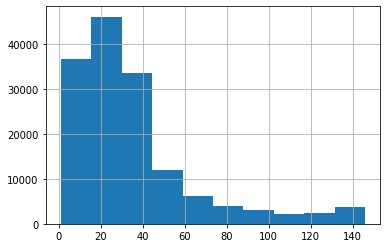

In [10]:
train.doc_len.hist()

<AxesSubplot:>

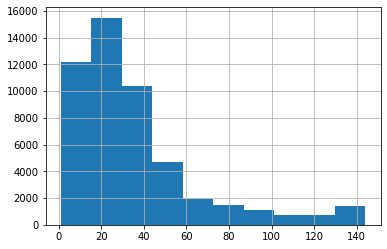

In [11]:
test.doc_len.hist()

In [12]:
# null 값 있는 자료 삭제
n_idx_tr = train.loc[train['document'].isnull()].index
train.drop(index=n_idx_tr, inplace=True)
train.loc[train['document'].isnull()]

,id,document,label,doc_len


In [13]:
print(train['doc_len'].max())

146


In [14]:
# null 값 있는 자료 삭제
n_idx_ts = test.loc[test['document'].isnull()].index
test.drop(index=n_idx_ts, inplace=True)
test.loc[test['document'].isnull()]

,id,document,label,doc_len


In [15]:
print(test['doc_len'].max())

144


In [16]:
# 중복 확인
print(len(train.loc[train['document'].duplicated()]))
print(train['document'].duplicated().sum())

3813
3813


In [17]:
# 중복 확인
print(len(test.loc[test['document'].duplicated()]))
print(test['document'].duplicated().sum())

840
840


In [18]:
#중복 삭제
train = train.drop_duplicates(subset='document')
test = test.drop_duplicates(subset='document')

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
 3   doc_len   146182 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
 3   doc_len   49157 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.9+ MB


In [21]:
all_doc = np.concatenate((train['document'].values,test['document'].values)) 

In [22]:
import re
from konlpy.tag import Mecab

In [23]:
def clean_sentence(sentence):
#         mecab = Mecab()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) 
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z!.,?]+", " ", sentence)
#         sentence = ' '.join(mecab.morphs(sentence))
        return sentence

In [24]:
filtered_corpus = []
for i in all_doc :
    sentence = clean_sentence(i)
    filtered_corpus.append(sentence)
train_f = filtered_corpus[:146182]
test_f = filtered_corpus[146182:]
all_doc_f = np.concatenate((train_f,test_f))

In [25]:
test['document'].head()

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
Name: document, dtype: object

In [26]:
train_f = filtered_corpus[:146182]
test_f = filtered_corpus[146182:]

In [27]:
all_doc_f = np.concatenate((train_f,test_f))

## Step 2 : tokenizing

In [28]:
#unique한 단어 확인

temp_doc= set()
for i in all_doc_f :
    temp_doc |= set(i.split())
    
len(temp_doc)

356896

In [29]:
# #sentence piece model training
# np.random.seed(0)
# np.random.shuffle(all_doc_f)

import sentencepiece as spm
# temp_file = 'nlp16.train.ko.temp'
# vocab_size = 32000

# with open(temp_file, 'w') as f:
#     for row in all_doc_f[:15000]:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
#         f.write(str(row) + '\n')
        
# spm.SentencePieceTrainer.Train( 
#     '--input={} --model_prefix=nlp16 --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
# )

In [30]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load(f'nlp16.model')

True

In [31]:
test_txt = '아빠가 가방을 들고 있어요'

In [32]:
tokenizer.EncodeAsPieces(test_txt)

['▁아빠', '가', '▁가방', '을', '▁들', '고', '▁있', '어요']

In [33]:
from transformers import AutoTokenizer

tokenizer_k = AutoTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [34]:
# sentence piece 와 bert 모델 토크나이져와 유사하게 나오고 있으나, 워드 인덱싱 체게가 달라서 사용하기에는 어려움
print(tokenizer.EncodeAsPieces(test_txt))
print(tokenizer.Encode(test_txt))

['▁아빠', '가', '▁가방', '을', '▁들', '고', '▁있', '어요']
[1053, 30590, 6147, 30608, 28, 30585, 37, 1312]


In [35]:
print(tokenizer_k.tokenize(test_txt))
print(tokenizer_k.encode(test_txt))

['아빠', '##가', '가방', '##을', '들', '##고', '있', '##어요']
[2, 5091, 2116, 6840, 2069, 882, 2088, 1513, 10283, 3]


In [36]:
# data 준비
print(len(train_f) == len(train['label']))
print(len(test_f) == len(test['label']))

True
True


In [37]:
tokenizer_k.model_max_length

512

In [38]:
tokenizer_k.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [39]:
# huggingface framework 사용을 위해 데이터 준비
train_ = pd.DataFrame({'values' : train_f, 'label' : train['label']}).reset_index(drop=True)
test_ = pd.DataFrame({'values' : test_f, 'label' : test['label']}).reset_index(drop=True)

# random sampling 100,000 for training
train_xx1 = train_.sample(100000, random_state=123).reset_index(drop=True)

# random sampling 70,000 for training
train_x1 = train_.sample(70000, random_state=123).reset_index(drop=True)

# random sampling 30,000 for training
train_1 = train_.sample(30000, random_state=123).reset_index(drop=True)

# random sampling 15,000 for training and 1,000 for test
train_ = train_.sample(15000, random_state=123).reset_index(drop=True)
test_ = test_.sample(1000, random_state=123).reset_index(drop=True)

In [40]:
from datasets import Dataset
import datasets

train_d = Dataset.from_pandas(train_)
train_d1 = Dataset.from_pandas(train_1)
train_d2 = Dataset.from_pandas(train_x1)
train_d3 = Dataset.from_pandas(train_xx1)
test_d = Dataset.from_pandas(test_)

# datasetdict형태로 transformation
dataset = datasets.DatasetDict({"train":train_d, "train_l": train_d1, "train_xl": train_d2,"train_xxl": train_d3,"test":test_d})

In [41]:
from datasets import ClassLabel

#int2str 사용 가능하게 label 값을 classlabel 객채로 변환, 
dataset['train'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

dataset['train_l'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

dataset['train_xl'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

dataset['train_xxl'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

dataset['test'].features['label'] = ClassLabel(
    num_classes=2, 
    names=['negative','positive'])

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['values', 'label'],
        num_rows: 15000
    })
    train_l: Dataset({
        features: ['values', 'label'],
        num_rows: 30000
    })
    train_xl: Dataset({
        features: ['values', 'label'],
        num_rows: 70000
    })
    train_xxl: Dataset({
        features: ['values', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['values', 'label'],
        num_rows: 1000
    })
})

In [43]:
# 데이터 값 최종 확인
dataset.set_format(type='pandas')
df = dataset['train'][:]

In [44]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,values,label,label_name
0,세월을 무시하는 상콤한 하이틴무비,1,positive
1,일베충은 보고 반성할것,1,positive
2,대만ㅅㅁ섬짱개들 이따구 쓰레기영화 만들거잇네이따걸왜 상영허냐 ! ! !,0,negative
3,역시 한국 영화다 보니까 스토리가좀,0,negative
4,평점을 보니 초딩들에게는 점짜리 영화인 듯,0,negative


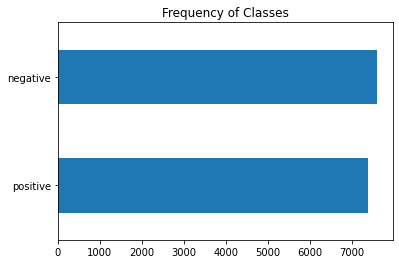

In [45]:
import matplotlib.pyplot as plt
#레이블 값 균형이 잡혀있는지 확인
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [46]:
# 인코딩하여 최종 데이터 dict 저장
dataset.set_format(type=None)
def tokenize(batch):
    return tokenizer_k(batch['values'], padding=True, truncation=True)

In [47]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
# check columns
print(dataset_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'token_type_ids', 'values']


## Step 3 : modeling

### 3.1 Baseline Model

In [49]:
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification, AutoModel

In [50]:
model_ckpt = 'klue/bert-base' #load model by huggingface checkpoint id

In [51]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = (AutoModel
         .from_pretrained(model_ckpt)
         .to(device))

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
text = '와! 정말 재밌다~'
inputs = tokenizer_k(text, return_tensors ='pt')
print(f"입력 텐서 크기 : {inputs['input_ids'].size()}")

입력 텐서 크기 : torch.Size([1, 8])


In [53]:
# feature extraction test
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad() :
    outputs = model(**inputs)
print(outputs.last_hidden_state)

tensor([[[ 3.1418e-01, -1.1972e+00, -1.6140e-01,  ...,  7.3959e-01,
          -1.7515e+00,  6.8540e-01],
         [ 5.2498e-01, -6.4417e-01, -1.1196e-01,  ...,  6.5214e-01,
           7.2646e-01,  8.4864e-01],
         [-7.1085e-02, -2.5374e-01,  2.3147e-01,  ..., -1.0668e+00,
           1.2168e-01,  2.2308e-01],
         ...,
         [-8.5548e-01, -4.1786e-02, -1.0770e+00,  ..., -1.9630e-02,
          -8.9644e-01,  3.0567e-01],
         [-2.8063e-01,  2.0007e-03, -2.2443e-02,  ..., -8.5091e-03,
          -2.5301e-01,  1.1437e-01],
         [ 1.1114e+00, -5.0673e-01,  4.0306e-01,  ...,  7.6922e-01,
          -2.0717e+00,  1.5237e+00]]], device='cuda:0')


In [54]:
outputs.pooler_output.size() #CLS token hidden만 사용

torch.Size([1, 768])

In [55]:
def extract_hidden_states(batch) :
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer_k.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).pooler_output 
        
    return {'hidden_state': last_hidden_state.cpu().numpy()}

In [56]:
tokenizer_k.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [57]:
dataset_encoded.set_format('torch', columns =tokenizer_k.model_input_names) # 사용할 컬럼만 pytorch tensor로 변환

In [58]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched =True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/70 [00:00<?, ?ba/s]

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [63]:
dataset_hidden['train'].column_names

['values',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [60]:
# train, test set split
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_train_l = np.array(dataset_hidden['train_l']['hidden_state'])
X_train_xl = np.array(dataset_hidden['train_xl']['hidden_state'])
X_train_xxl = np.array(dataset_hidden['train_xl']['hidden_state'])

y_train = np.array(dataset_hidden['train']['label'])
y_train_l = np.array(dataset_hidden['train_l']['label'])
y_train_xl = np.array(dataset_hidden['train_xl']['label'])
y_train_xxl = np.array(dataset_hidden['train_xl']['label'])

X_valid = np.array(dataset_hidden['test']['hidden_state'])
y_valid = np.array(dataset_hidden['test']['label'])
print(X_train.shape, y_train.shape)
print(X_train_l.shape,y_train_l.shape)
print(X_train_xl.shape,y_train_xl.shape)
print(X_valid.shape,y_valid.shape)

(15000, 768) (15000,)
(30000, 768) (30000,)
(70000, 768) (70000,)
(1000, 768) (1000,)


In [61]:
from sklearn.naive_bayes import GaussianNB
baseline_model = GaussianNB()
baseline_model.fit(X_train, y_train)

GaussianNB()

In [62]:
from sklearn.metrics import accuracy_score
prediction = baseline_model.predict(X_valid)
accuracy = accuracy_score(y_valid, prediction)
print(f'baseline model accuracy score : {accuracy}')

baseline model accuracy score : 0.707


In [63]:
results_dict = {'GNB_base_15000' : accuracy} # 비교 분석을 위해 결과 저장

In [80]:
## 30000 개 데이터

In [64]:
baseline_model_l = GaussianNB()
baseline_model_l.fit(X_train_l, y_train_l)
prediction = baseline_model_l.predict(X_valid)
accuracy_l = accuracy_score(y_valid, prediction)
print(f'baseline model-l accuracy score : {accuracy_l}')

baseline model-l accuracy score : 0.707


In [65]:
results_dict['GNB_base_30000'] = accuracy_l

In [66]:
baseline_model_xl = GaussianNB()
baseline_model_xl.fit(X_train_xl, y_train_xl)
prediction = baseline_model_xl.predict(X_valid)
accuracy_xl = accuracy_score(y_valid, prediction)
print(f'baseline model-xl accuracy score : {accuracy_xl}')

baseline model-xl accuracy score : 0.705


In [67]:
results_dict['GNB_base_70000'] = accuracy_xl

In [69]:
baseline_model_xxl = GaussianNB()
baseline_model_xxl.fit(X_train_xxl, y_train_xxl)
prediction = baseline_model_xxl.predict(X_valid)
accuracy_xxl = accuracy_score(y_valid, prediction)
print(f'baseline model-xxl accuracy score : {accuracy_xxl}')

baseline model-xxl accuracy score : 0.705


In [70]:
results_dict['GNB_base_10000'] = accuracy_xxl

In [71]:
del X_train 
del X_train_l
del X_train_xl
del X_train_xxl

del y_train 
del y_train_l
del y_train_xl
del y_train_xxl

### 3.2 Fine-Tuning

In [73]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [74]:
#config
from transformers import AutoConfig
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
klue_config = AutoConfig.from_pretrained(model_ckpt,
                                        num_labels=2,
                                        id2label =id2label,
                                        label2id=label2id)

In [75]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(model_ckpt, config = klue_config)
            .to(device))

In [76]:
#configure training arg
batch_size= 64
num_epochs = 2

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir= "finetuned_model",
                                  num_train_epochs = num_epochs,
                                  log_level='error',
                                  weight_decay=0.01,
                                  per_device_train_batch_size =batch_size,
                                  per_device_eval_batch_size =batch_size,
                                  evaluation_strategy ='epoch',
                                  save_strategy = 'epoch',
                                  fp16 =True,#quantization
                                  disable_tqdm=False )

In [77]:
# generate data collator
from transformers import DataCollatorWithPadding
data_collator =  DataCollatorWithPadding(tokenizer=tokenizer_k, return_tensors="pt")

In [78]:
tokenizer_k.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [79]:
#trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train'],
    eval_dataset=dataset_hidden['test'],
    tokenizer=tokenizer_k)

In [80]:
dataset_hidden.set_format(None)

In [81]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.330658
2,No log,0.358828


TrainOutput(global_step=470, training_loss=0.2802998644240359, metrics={'train_runtime': 242.5527, 'train_samples_per_second': 123.684, 'train_steps_per_second': 1.938, 'total_flos': 1757499627600000.0, 'train_loss': 0.2802998644240359, 'epoch': 2.0})

In [82]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy1 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))

In [83]:
print(f" KLUE_Bert_15000 :{accuracy1}")

 KLUE_Bert_15000 :0.864


In [84]:
results_dict['KLUE_Bert_Finetuned_15000'] = accuracy1

In [86]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제
gc.collect()

0

### Freezing Weight Parameters

In [87]:
# model
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, config = klue_config)
         .to(device))

In [88]:
# freeze all encoder layer
for name, param in model.named_parameters():
     if name.startswith("bert.encoder.layer"): # choose whatever you like here
        param.requires_grad = False

In [89]:
dataset_hidden.set_format(None)

In [90]:
#trainer
dataset_hidden.set_format(None)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train'],
    eval_dataset=dataset_hidden['test'],
    tokenizer=tokenizer_k)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.385442
2,No log,0.380265


TrainOutput(global_step=470, training_loss=0.42131113904587764, metrics={'train_runtime': 182.0906, 'train_samples_per_second': 164.753, 'train_steps_per_second': 2.581, 'total_flos': 1757499627600000.0, 'train_loss': 0.42131113904587764, 'epoch': 2.0})

In [91]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy2 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))
print(f" KLUE_Bert_freeze_all_15000 :{accuracy2}")

 KLUE_Bert_freeze_all_15000 :0.835


In [92]:
results_dict['KLUE_Bert_Finetuned_Freeze_all_15000'] = accuracy2

In [94]:
del model
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제
gc.collect()

0

In [95]:
# model
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, config = klue_config)
         .to(device))

In [96]:
# train only last layer
for name, param in model.named_parameters():
     if name.startswith("bert.encoder.layer"): # choose whatever you like here
            if name.startswith("bert.encoder.layer.11") :
                continue
            else:
                param.requires_grad = False

In [97]:
#trainer
dataset_hidden.set_format(None)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train'],
    eval_dataset=dataset_hidden['test'],
#     compute_metrics = compute_metrics,
    tokenizer=tokenizer_k)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.355520
2,No log,0.357624


TrainOutput(global_step=470, training_loss=0.37620404831906584, metrics={'train_runtime': 187.4599, 'train_samples_per_second': 160.034, 'train_steps_per_second': 2.507, 'total_flos': 1757499627600000.0, 'train_loss': 0.37620404831906584, 'epoch': 2.0})

In [98]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy3 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))
print(f" KLUE_Bert_freeze_last_15000 :{accuracy3}")

 KLUE_Bert_freeze_last_15000 :0.845


In [99]:
results_dict['KLUE_Bert_Finetuned_Freeze_last(12)_15000'] = accuracy3

In [103]:
del model
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제
gc.collect()

0

In [104]:
# model
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, config = klue_config)
         .to(device))

In [105]:
# train only 4 layer
for name, param in model.named_parameters():
     if name.startswith("bert.encoder.layer"): # choose whatever you like here
            if name.startswith("bert.encoder.layer.11") or name.startswith("bert.encoder.layer.10") or name.startswith("bert.encoder.layer.9") or name.startswith("bert.encoder.layer.8"):
                continue
            else:
                param.requires_grad = False

In [106]:
#trainer
dataset_hidden.set_format(None)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train'],
    eval_dataset=dataset_hidden['test'],
    tokenizer=tokenizer_k)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.339655
2,No log,0.351907


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


TrainOutput(global_step=470, training_loss=0.3230618091339761, metrics={'train_runtime': 203.6257, 'train_samples_per_second': 147.329, 'train_steps_per_second': 2.308, 'total_flos': 1757499627600000.0, 'train_loss': 0.3230618091339761, 'epoch': 2.0})

In [107]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy4 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))
print(f" KLUE_Bert_freeze_last4_15000 :{accuracy4}")

 KLUE_Bert_freeze_last4_15000 :0.851


In [108]:
results_dict['KLUE_Bert_Finetuned_Freeze_layer(12,11,10,9)_15000'] = accuracy4

## Step 4 : evaluation

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

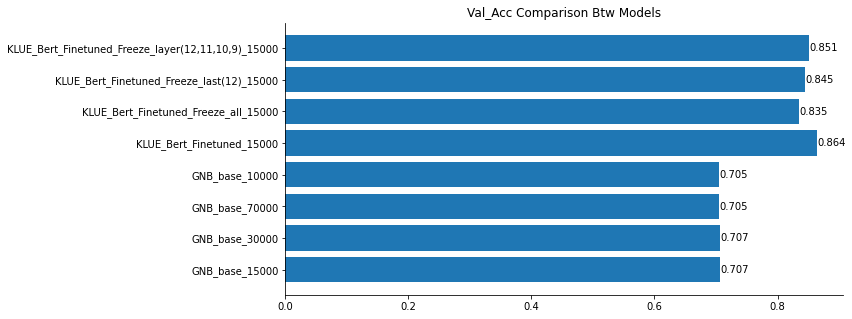

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
bar = ax.barh(list(results_dict.keys()),results_dict.values())
ax.bar_label(bar)
sns.despine()
plt.title('Val_Acc Comparison Btw Models')
plt.show()

## Step 5 : optimize results - FineTune 70,000 & 10,000,000

In [128]:
# del model
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제
gc.collect()

0

In [113]:
#trainer
dataset_hidden.set_format(None)
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train_xl'],
    eval_dataset=dataset_hidden['test'],
    tokenizer=tokenizer_k)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.288100,0.313678
2,0.170500,0.320241


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


TrainOutput(global_step=2188, training_loss=0.23720472255616126, metrics={'train_runtime': 1081.0086, 'train_samples_per_second': 129.509, 'train_steps_per_second': 2.024, 'total_flos': 9064998079200000.0, 'train_loss': 0.23720472255616126, 'epoch': 2.0})

In [116]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy6 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))
print(f" KLUE_Bert_finetuned_all_70000 :{accuracy6}")

 KLUE_Bert_finetuned_all_70000 :0.873


In [117]:
results_dict['KLUE_Bert_FineTuned_70000'] = accuracy6

90% val_acc을 넘으려면, 데이터를 100,000정도로 올리고, 몇가지 optimizer부분에 몇가지 하이퍼 파라미터 정도만 수정하면 결과를 얻을 수 있을 것 같다.

In [120]:
#trainer
dataset_hidden.set_format(None)
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator = data_collator,
    train_dataset=dataset_hidden['train_xxl'],
    eval_dataset=dataset_hidden['test'],
    tokenizer=tokenizer_k)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.269000,0.269012
2,0.166500,0.302480


TrainOutput(global_step=3126, training_loss=0.233565859510894, metrics={'train_runtime': 1529.1134, 'train_samples_per_second': 130.795, 'train_steps_per_second': 2.044, 'total_flos': 1.2949997256e+16, 'train_loss': 0.233565859510894, 'epoch': 2.0})

In [121]:
dataset_hidden.set_format(None, columns = tokenizer_k.model_input_names )
label = dataset_hidden['test']['label']
predictions = np.argmax(trainer.predict(dataset_hidden['test']).predictions, axis=-1)
accuracy7 = accuracy_score(np.array(label, np.int32), np.array(predictions, np.int32))
print(f" KLUE_Bert_finetuned_all_100000 :{accuracy7}")

 KLUE_Bert_finetuned_all_100000 :0.891


In [124]:
results_dict['KLUE_Bert_FineTuned_100000'] = accuracy7

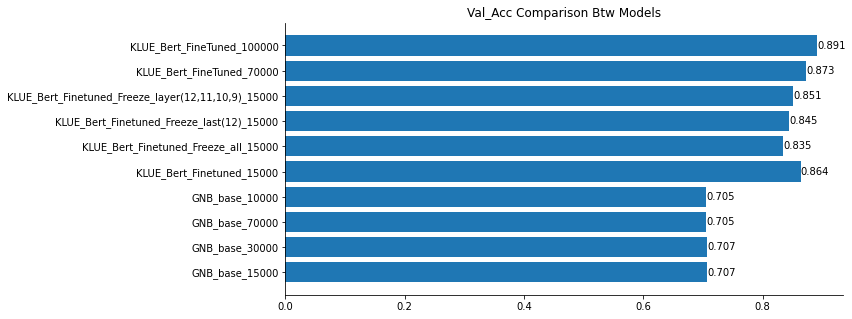

In [125]:
fig, ax = plt.subplots(figsize=(10,5))
bar = ax.barh(list(results_dict.keys()),results_dict.values())
ax.bar_label(bar)
sns.despine()
plt.title('Val_Acc Comparison Btw Models')
plt.show()

## Step(EXTRA) : Compare w/ other finetuned model in hunggingface

In [126]:
from transformers import pipeline
classifier = pipeline(
    "sentiment-analysis", model="sangrimlee/bert-base-multilingual-cased-nsmc"
)

Downloading:   0%|          | 0.00/932 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/297 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [129]:
predictions =[]
for i in dataset['test']['values'] :
    predictions.append(classifier(i)[0]['label'])

In [130]:
label=dataset['test']['label']

In [131]:
for i in range(len(predictions)):
    if predictions[i] =='negative':
        predictions[i] = 0
    else :
        predictions[i] = 1

In [132]:
results_dict['sangrimlee/bert-base-multilingual-cased-nsmc'] = accuracy_score(label, predictions)

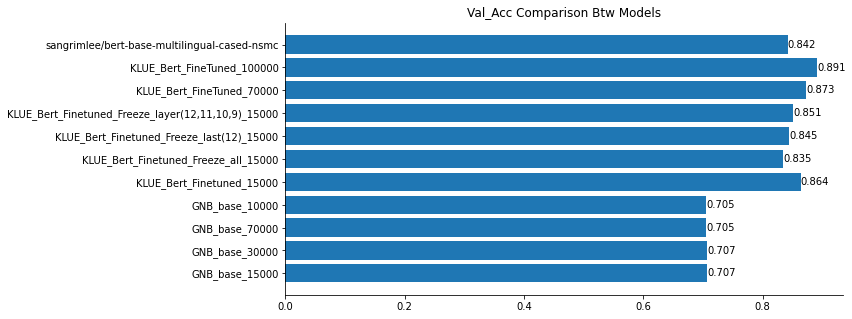

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
bar = ax.barh(list(results_dict.keys()),results_dict.values())
ax.bar_label(bar)
sns.despine()
plt.title('Val_Acc Comparison Btw Models')
plt.show()

## Conclusion

90% 은 넘지는 못했습니다. ㅜㅜ 데이터를 더 올리면 분명 넘을 수 있을 것 같네요.
KLUE BERT가 또한 단순 NSMC로 finetune된 모델보다도 성능이 훨씬 좋게 나오네요.